# Player Progression Simulation

Stanley Hsu and Jonathan Mitchum

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.optimize import curve_fit

import math
from random import random
from alive_progress import alive_bar

pd.options.mode.chained_assignment = None

## Load Data

In [2]:
def load_history():
    history = pd.read_csv(
        r"C:\Users\hsu_s\Projects\Personal\tt-ds-proj\data\player-history.csv"
    )
    history[
        [
            "Rank",
            "USATT#",
            "Database#",
            "Tournament Rating",
            "League Rating",
            "Initial Rating",
            "Final Rating",
        ]
    ] = history[
        [
            "Rank",
            "USATT#",
            "Database#",
            "Tournament Rating",
            "League Rating",
            "Initial Rating",
            "Final Rating",
        ]
    ].apply(
        pd.to_numeric, errors="coerce"
    )
    history[["Last Played Tournament", "Last Played League"]] = history[
        ["Last Played Tournament", "Last Played League"]
    ].apply(pd.to_datetime)
    history["Start Date"] = (
        pd.to_datetime(history["Start Date"], format="%Y-%m-%d", errors="coerce")
        .fillna(
            pd.to_datetime(history["Start Date"], format="%m-%d-%Y", errors="coerce")
        )
        .fillna(
            pd.to_datetime(history["Start Date"], format="%m/%d/%Y", errors="coerce")
        )
    )
    history["End Date"] = (
        pd.to_datetime(history["End Date"], format="%Y-%m-%d", errors="coerce")
        .fillna(pd.to_datetime(history["End Date"], format="%m-%d-%Y", errors="coerce"))
        .fillna(pd.to_datetime(history["End Date"], format="%m/%d/%Y", errors="coerce"))
    )

    return history

In [3]:
def load_stats():
    stats = pd.read_csv(
        r"C:\Users\hsu_s\Projects\Personal\tt-ds-proj\data\player-stats.csv"
    )
    stats[
        [
            "Rank",
            "USATT#",
            "Database#",
            "Tournament Rating",
            "League Rating",
            "Max Rating",
            "Tournaments Played",
        ]
    ] = stats[
        [
            "Rank",
            "USATT#",
            "Database#",
            "Tournament Rating",
            "League Rating",
            "Max Rating",
            "Tournaments Played",
        ]
    ].apply(
        pd.to_numeric, errors="coerce"
    )
    stats[["Last Played Tournament", "Last Played League", "Date of Birth"]] = stats[
        ["Last Played Tournament", "Last Played League", "Date of Birth"]
    ].apply(pd.to_datetime)
    stats[["Age"]] = stats[["Age"]].apply(pd.to_timedelta)

    return stats

In [4]:
players = load_stats()
history = load_history()

# exclude unrated players in analysis
players = players[players['Tournament Rating'] > 0]

history['Rating Change'] = history['Final Rating'] - history['Initial Rating']

## Clean Data

We want to limit the scope of our analysis to only include players who started their table tennis careers in the US.

In [5]:
# valid player defined as players who didn't gain more than 1500 points in their first tournament
def valid_player(player):
    r_hist = history[history['Database#'] == player['Database#']]
    if len(r_hist) == 0:
        return False

    first_tournament = r_hist.iloc[-1]
    if first_tournament['Rating Change'] <= 1500:
        return True
    return False

# filter out all invalid players
players['Valid Player'] = players.apply(valid_player, axis=1)
valid = players[['Database#', 'Valid Player']]
history = history.merge(valid, how='inner', on='Database#')
players = players[players['Valid Player'] == True]
history = history[history['Valid Player'] == True]

rating_data = history[['Initial Rating', 'Final Rating', 'Rating Change']]

## Part 1 - Define Mean and Standard Deviation Functions

In order to model the probabilities of rating changes at each rating with a normal distribution, we need to know if the distributions in our data resemble approximate normal curves.

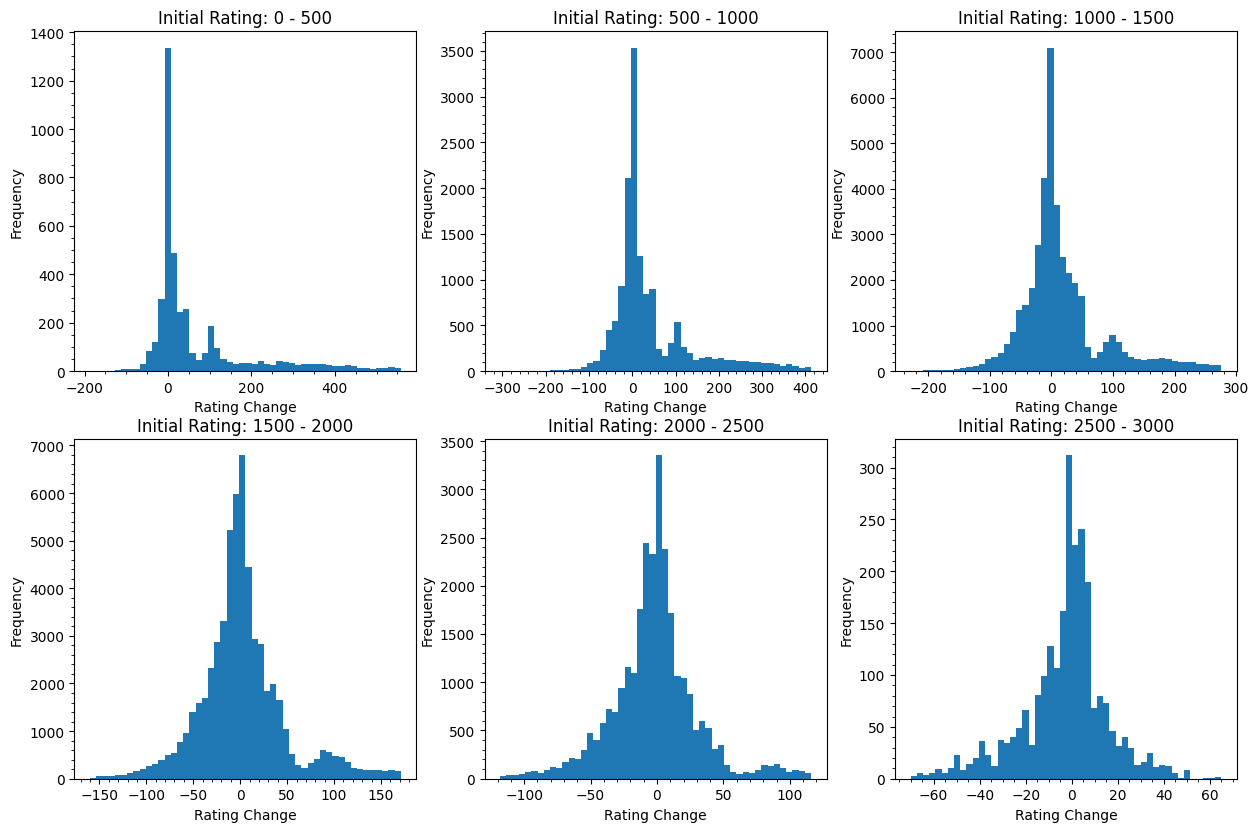

In [6]:
def plotRatingChangeDistributions(arr, interval, bins=50):
    plt.title(f'{interval}')
    plt.hist(arr, bins=bins)
    plt.xlabel('Rating Change')
    plt.ylabel('Frequency')
    plt.minorticks_on()

plt.figure(figsize=(15,15))
ranges = np.linspace(0, 3000, 7).astype(int)
for i in range(len(ranges) - 1):
    r = rating_data[(rating_data['Initial Rating'] > ranges[i]) & (rating_data['Initial Rating'] <= ranges[i+1])]
    filtered_r = r[(np.abs(ss.zscore(r)) < 3).all(axis=1)]
    plt.subplot(3, 3, i+1)
    plotRatingChangeDistributions(filtered_r['Rating Change'], f"Initial Rating: {ranges[i]} - {ranges[i+1]}")

In these distribution graphs, we can see that at lower ratings, our distributions are doubly peaked, with one peak usually around zero and the other around a hundred. The first peak represents the casual players at that level who hover around that rating and just play for fun. The second peak represents the rapidly improving players who are usually juniors. At higher rating ranges, we see that the distribution of rating changes more closely resembes a normal distribution. For the sake of our model, we will assume that the distributions of rating changes at all elos can be modeled by a normal curve.

Now, we will fit two models, one for rating change means and one for rating change standard deviations. These two functions will be used to define a normal model of rating changes at every rating.

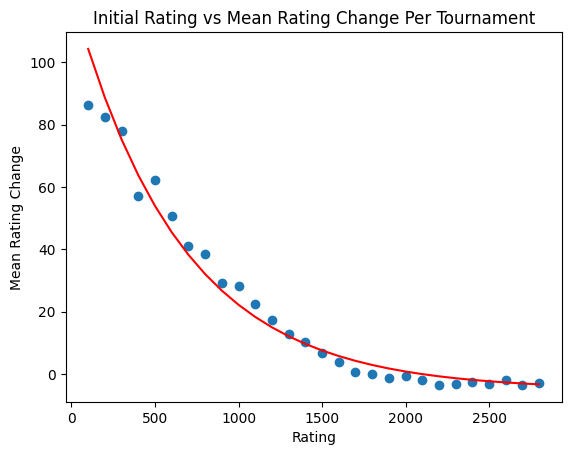

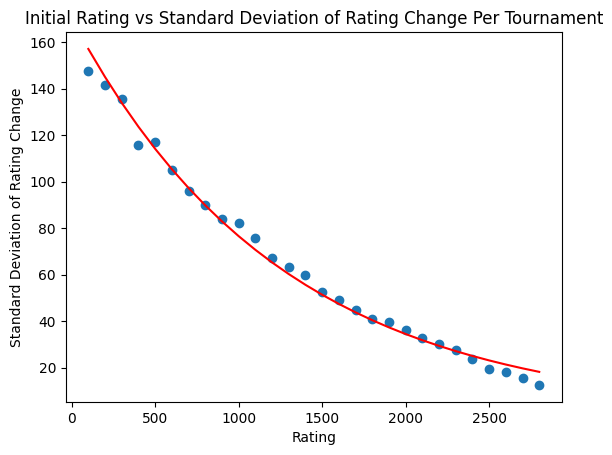

In [7]:
# define intervals in our data to check the mean and standard deviations of
ranges = np.linspace(100, 2900, 29)
means = np.array([])
stdevs = np.array([])
for i in range(len(ranges) - 1):
    # put together the data in our interval
    r = rating_data[(rating_data['Initial Rating'] > ranges[i]) & (rating_data['Initial Rating'] <= ranges[i+1])]

    # filter out outliers
    filtered_r = r[(np.abs(ss.zscore(r)) < 3).all(axis=1)]

    # find mean and standard deviation
    filtered_r_mean = np.mean(filtered_r['Rating Change'])
    filtered_r_stdev = np.std(filtered_r['Rating Change'])

    # append it to our data
    means = np.append(means, filtered_r_mean)
    stdevs = np.append(stdevs, filtered_r_stdev)

# fit our models for means and standard deviations
mean_translate = min(math.floor(min(means)) - 1, 0)
means_params = np.polyfit(ranges[:-1], np.log(means - mean_translate), 1, w=np.sqrt(means - mean_translate))

stdev_translate = min(math.floor(min(stdevs)) - 1, 0)
stdevs_params = np.polyfit(ranges[:-1], np.log(stdevs - stdev_translate), 1, w=np.sqrt(stdevs - stdev_translate))

def means_func(x):
    return np.e ** means_params[1] * np.e ** (means_params[0] * x) + mean_translate

def stdevs_func(x):
    return np.e ** stdevs_params[1] * np.e ** (stdevs_params[0] * x) + stdev_translate

# graph our models
init_ratings = ranges[:-1]

plt.plot(init_ratings, means, 'o')
plt.plot(init_ratings, means_func(init_ratings), 'r')
plt.title('Initial Rating vs Mean Rating Change Per Tournament')
plt.xlabel('Rating')
plt.ylabel('Mean Rating Change')
plt.show()

plt.plot(init_ratings, stdevs, 'o')
plt.plot(init_ratings, stdevs_func(init_ratings), 'r')
plt.title('Initial Rating vs Standard Deviation of Rating Change Per Tournament')
plt.xlabel('Rating')
plt.ylabel('Standard Deviation of Rating Change')
plt.show()

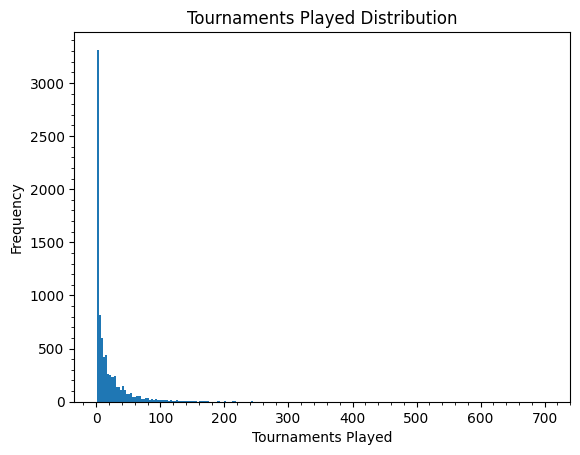

In [8]:
# visualize the distribution of tournaments played
plt.hist(players['Tournaments Played'], bins=len(np.unique(players['Tournaments Played'])))
plt.title('Tournaments Played Distribution')
plt.xlabel('Tournaments Played')
plt.ylabel('Frequency')
plt.minorticks_on()
plt.show()

## Part 2: Model Player Progression

Next, we want to model a player and how they will progress over time. The Player class includes this information, along with functions that allows it to "play" a tournament and determine if it has plateaued.

In [9]:
class Player:
    def __init__(self, initial_rating=0):
        self.rating = initial_rating
        self.tournament_count = 0
        self.rating_history = [0]
        self.momentum = 0
        self.plateau_count = 0

    def playTournament(self):
        # rating change randomly chosen from normal distribution defined by our mean and stdev functions
        r_mean = means_func(self.rating)
        r_stdev = stdevs_func(self.rating)
        r_change = ss.pearson3.rvs(loc=r_mean, scale=r_stdev, skew=-self.momentum)

        # update momentum
        self.momentum = (r_change - r_mean) / r_stdev

        # update player rating
        self.rating += r_change
        self.rating = max(0, int(self.rating))

        # add to history
        self.rating_history.append(self.rating)

        # update tournament count
        self.tournament_count += 1
    
    def isPlateau(self, plateau_lim):
        plateau_rating = self.rating_history[-(self.plateau_count+1)]
        if self.rating_history[-1] >= plateau_rating + stdevs_func(plateau_rating):
            self.plateau_count = 0
            return False
        
        self.plateau_count += 1
        return self.plateau_count >= plateau_lim

With our player model, we can now run simulations to model what an entire distribution of 12,000 players could look like.

|████████████████████████████████████████| 12000/12000 [100%] in 1:10.2 (171.09/ ▇▇▅ 2112/12000 [18%] in 11s (~53s, 18 ▅▇▇ 4052/12000 [34%] in 22s (~43s, 18 ▆█▆ 4766/12000 [40%] in 26s (~40s, 18 ▅▇▇ 5670/12000 [47%] in 33s (~37s, 17 ▅▃▁ 6700/12000 [56%] in 41s (~33s, 16 ▃▁▃ 6740/12000 [56%] in 42s (~33s, 16 ▄▆█ 7468/12000 [62%] in 45s (~28s, 16 ▄▆█ 10707/12000 [89%] in 1:03 (~8s, 1


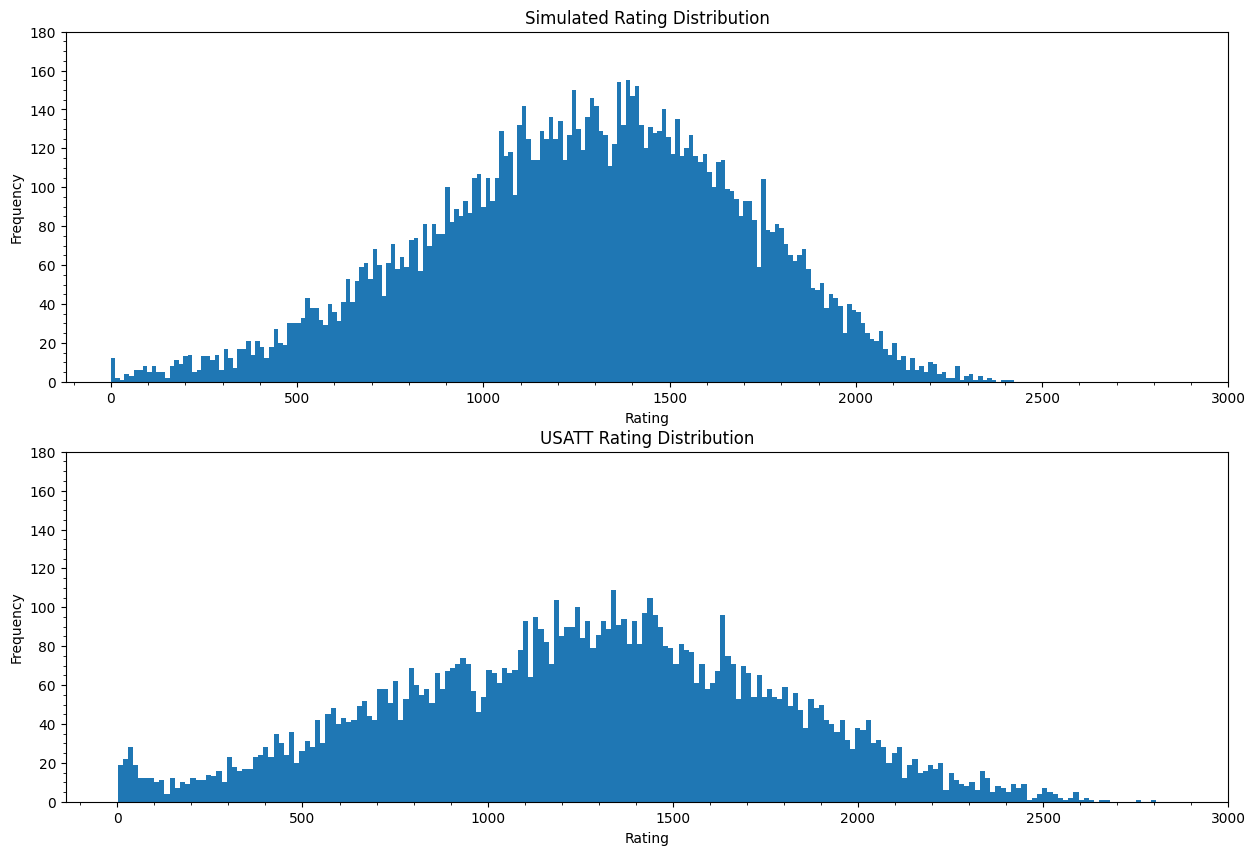

In [10]:
sim_count = 12000
plateau_lim = 10
player_list = []

with alive_bar(sim_count, force_tty=True) as bar:
    for i in range(sim_count):
        player = Player()
        num_tournaments = 100

        for j in range(num_tournaments):
            # update rating
            player.playTournament()

            # player has 25% chance of quitting if plateaued
            if player.isPlateau(plateau_lim) and random() < 0.25:
                break
        
        player_list.append(player)
        bar()

plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.title('Simulated Rating Distribution')
plt.hist([player.rating for player in player_list], bins=200)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(np.linspace(0, 3000, 7))
plt.yticks(np.linspace(0, 180, 10))
plt.minorticks_on()

plt.subplot(2,1,2)
plt.title('USATT Rating Distribution')
plt.hist(players['Tournament Rating'], bins=200)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.minorticks_on()
plt.xticks(np.linspace(0, 3000, 7))
plt.yticks(np.linspace(0, 180, 10))

plt.show()

## Part 3: Simulate Player Plateaus

We can also use our player model to determine a model that defines how long a plateau at any given rating will last.

In [19]:
sim_count = 10000
plateau_lens = []
plateau_ratings = []

with alive_bar(sim_count, force_tty=True) as bar:
    for i in range(sim_count):
        player = Player()
        currPlateauLen = 0

        for j in range(num_tournaments):
            player.playTournament()

            # we keep track of at what rating the player's plateau started at and how long it lasted
            if player.isPlateau(plateau_lim):
                currPlateauLen += 1
            elif currPlateauLen > 0:
                plateau_lens.append(currPlateauLen + plateau_lim - 1)
                plateau_ratings.append(player.rating_history[j - currPlateauLen - plateau_lim + 1])
                currPlateauLen = 0

        if currPlateauLen > 0:
            plateau_lens.append(currPlateauLen + plateau_lim - 1)
            plateau_ratings.append(player.rating_history[num_tournaments - currPlateauLen - plateau_lim + 1])
        bar()

|                                        | ▁▃▅ 1/10000 [0%] in 0s (~5:07, 32.6/s

|████████████████████████████████████████| 10000/10000 [100%] in 1:46.5 (93.93/s ▄▂▂ 1570/10000 [16%] in 17s (~1:29, 9 ▃▅▇ 5158/10000 [52%] in 55s (~52s, 94 ▇▅▃ 6449/10000 [64%] in 1:09 (~38s, 9 ▁▃▅ 7196/10000 [72%] in 1:17 (~30s, 9 ▂▂▄ 9095/10000 [91%] in 1:37 (~10s, 9


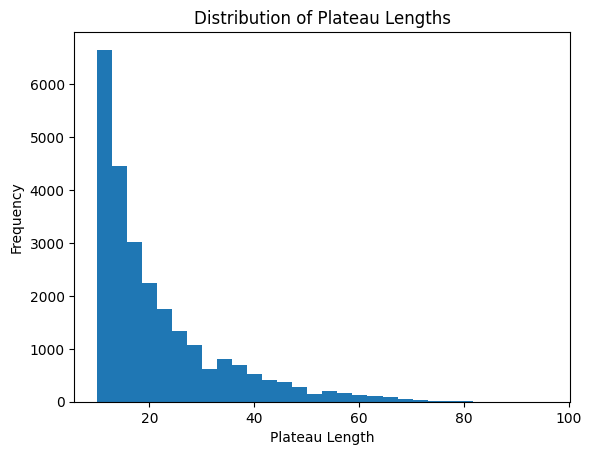

In [27]:
# quick visualization of the distribution of plateau lengths
plateau_data = pd.DataFrame(columns=['Rating', 'Length'])
plateau_data['Rating'] = plateau_ratings
plateau_data['Length'] = plateau_lens
plateau_data['Length'].plot(kind='hist', bins=30, title='Distribution of Plateau Lengths', xlabel='Plateau Length')
plt.show()

For our model, a normal distribution makes the most sense because you cannot have a negative mean plateau length.

Parameters of the curve:
Mean: 1677.6199345251473
Standard Deviation: 733.2952940071215
Scale: 12.740485256226929
Vertical Transform: 10


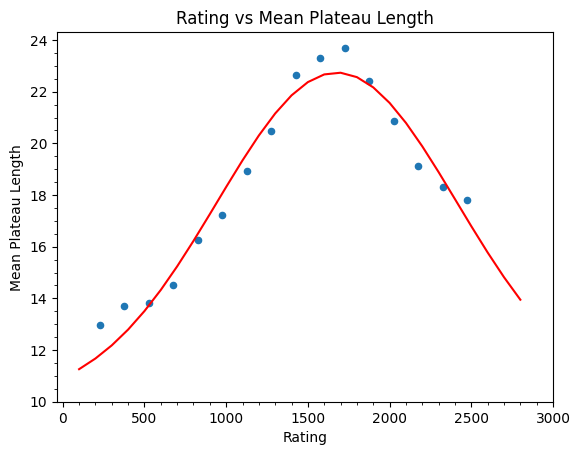

In [21]:
# intervals for generating data points about rating vs mean plateau length
bins = np.linspace(0, 3000, 21).astype(int)
plateau_data['bin'] = pd.cut(plateau_data['Rating'], bins)
plateau_means = pd.DataFrame(plateau_data.groupby('bin', observed=True)['Length'].mean())

# format our data into the table we want
plateau_means.index = pd.IntervalIndex(plateau_means.index)
plateau_means['Midpoint'] = plateau_means.index.mid
plateau_means = plateau_means.reset_index()
lengths = pd.DataFrame({'Midpoint': plateau_means['Midpoint'], 'Length': plateau_means['Length']})

# fit the parameters of a normal distribution curve using our data
def fit_lengths(x, scale, mu, sigma):
    return plateau_lim + scale * np.exp(-0.5 * ((x - mu) / sigma)**2)

parameters, covariance = curve_fit(fit_lengths, lengths['Midpoint'] / 100, lengths['Length'])

# define our plateau length function
print('Parameters of the curve:')
print(f'Mean: {parameters[1] * 100}')
print(f'Standard Deviation: {parameters[2] * 100}')
print(f'Scale: {parameters[0]}')
print(f'Vertical Transform: {plateau_lim}')

def lengths_func(x):
    return plateau_lim + parameters[0] * np.exp(-0.5 * ((x / 100 - parameters[1]) / parameters[2])**2)

# visualize our curve
lengths.plot(kind='scatter', x='Midpoint', y='Length', xlabel='Rating', ylabel='Average Plateau Length (tournaments)', title='Rating vs Plateau Length')
plt.plot(init_ratings, lengths_func(init_ratings), 'r')
plt.title('Rating vs Mean Plateau Length')
plt.xlabel('Rating')
plt.ylabel('Mean Plateau Length')
plt.xticks(np.linspace(0, 3000, 7))
plt.yticks(np.linspace(10, 24, 8))
plt.minorticks_on()
plt.show()